### Group Project Phase #2

For our predictive question, we are asking if specific quantitative characteristics of a track (danceability, energy, tempo) can help predict a new song's popularity on the music streaming service, Spotify.

Idea for Phase #2: Conduct classification analyses with ll combinations of predictive variables to see which results in the smallest RSME

In [120]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(RColorBrewer)

options(repr.plot.width= 30, repr.plot.height= 10)

In [121]:
set.seed(2022)

spotify_raw_data = read_csv("https://raw.githubusercontent.com/chrislukita/DSCI100-Group-Final/main/data/SpotifyDataset.csv")

Parsed with column specification:
cols(
  genre = col_character(),
  artist_name = col_character(),
  track_name = col_character(),
  track_id = col_character(),
  popularity = col_double(),
  acousticness = col_double(),
  danceability = col_double(),
  duration_ms = col_double(),
  energy = col_double(),
  instrumentalness = col_double(),
  key = col_character(),
  liveness = col_double(),
  loudness = col_double(),
  mode = col_character(),
  speechiness = col_double(),
  tempo = col_double(),
  time_signature = col_character(),
  valence = col_double()
)

Warning message:
“1 parsing failure.
   row col   expected     actual                                                                                             file
115177  -- 18 columns 15 columns 'https://raw.githubusercontent.com/chrislukita/DSCI100-Group-Final/main/data/SpotifyDataset.csv'
”


In [122]:
random_spotify = slice_sample(spotify_raw_data, n = 50000)

In [132]:
# spotify_wrangled = random_spotify %>%
#                     select(popularity, danceability) %>%
#                     na.omit(spotify_wrangled)

spotify_wrangled = random_spotify %>%
                    na.omit(spotify_wrangled)

In [133]:
spotify_wrangled = spotify_wrangled %>%
                    mutate(popular = popularity >= 65) %>%
                    mutate(popular = as.factor(popular))

levels(spotify_wrangled$popular)[2] <- 'Yes'
levels(spotify_wrangled$popular)[1] <- 'No'

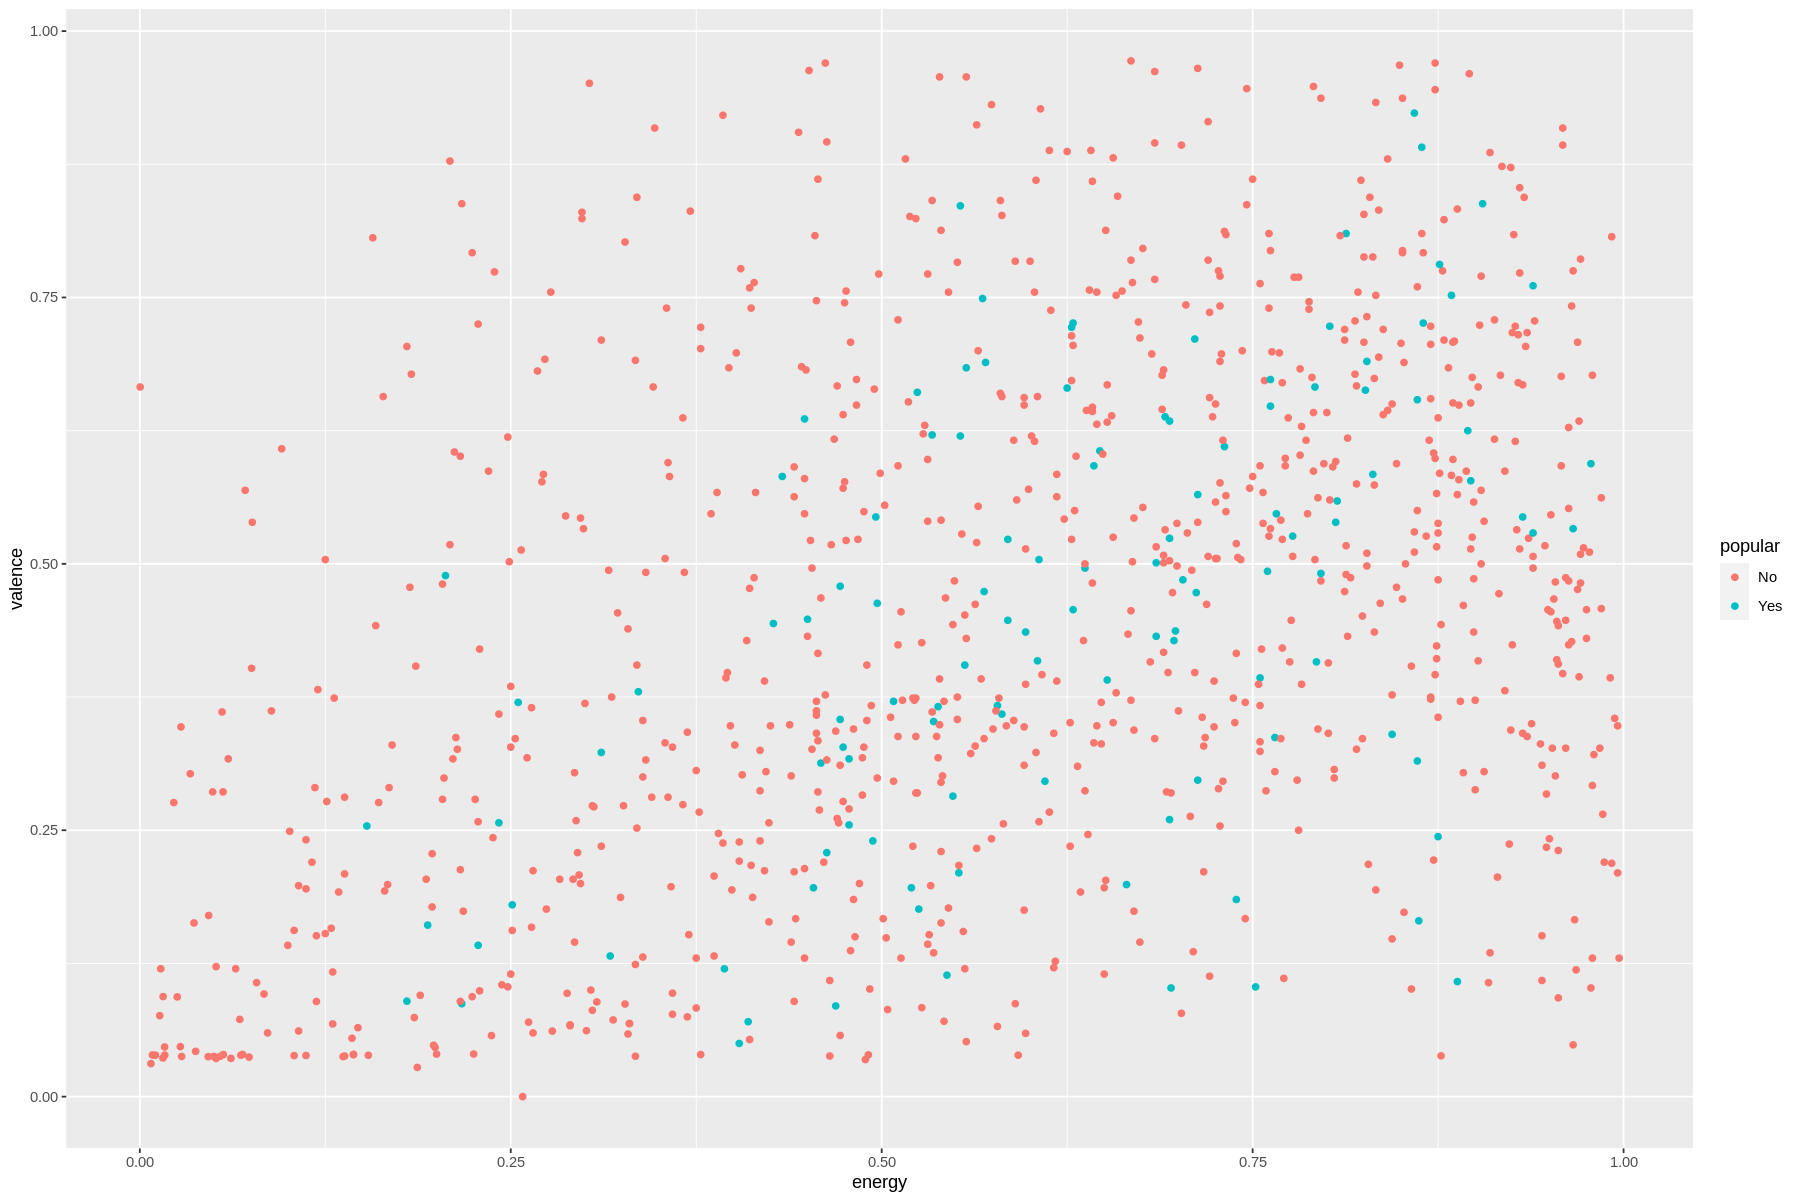

In [146]:
options(repr.plot.width= 15, repr.plot.height= 10)

spotify_really_small = slice_sample(spotify_wrangled, n = 1000)

popularity_plot = spotify_really_small %>%
                ggplot(aes(x = energy, y = danceability
                           , color = popular)) + 
                geom_point()

popularity_plot

In [126]:
spotify_split = initial_split(spotify_wrangled, prop = 0.75, strata = popular)

spotify_train = training(spotify_split)
spotify_test = testing(spotify_split)

In [127]:
spotify_proportions = spotify_train %>%
            group_by(popular) %>%
            summarize(n = n()) %>%
            mutate(percent = 100*n/nrow(spotify_train))

spotify_proportions

`summarise()` ungrouping output (override with `.groups` argument)



popular,n,percent
<fct>,<int>,<dbl>
No,21179,56.47583
Yes,16322,43.52417


Tuning model to find best K value using two predictors

In [109]:
spotify_recipe <- recipe(popular ~ danceability + energy, data = spotify_train)

spotify_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

In [110]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

In [111]:
spotify_vfold <- vfold_cv(spotify_train, v = 5, strata = popular)

In [112]:
spotify_results <- workflow() %>%
                      add_recipe(spotify_recipe) %>%
                      add_model(knn_tune) %>%
                      tune_grid(resamples = spotify_vfold, grid = 10) %>%
                      collect_metrics()

In [ ]:
accuracies <- spotify_results %>% 
        filter(.metric == "accuracy")

Plot accuracies vs. K

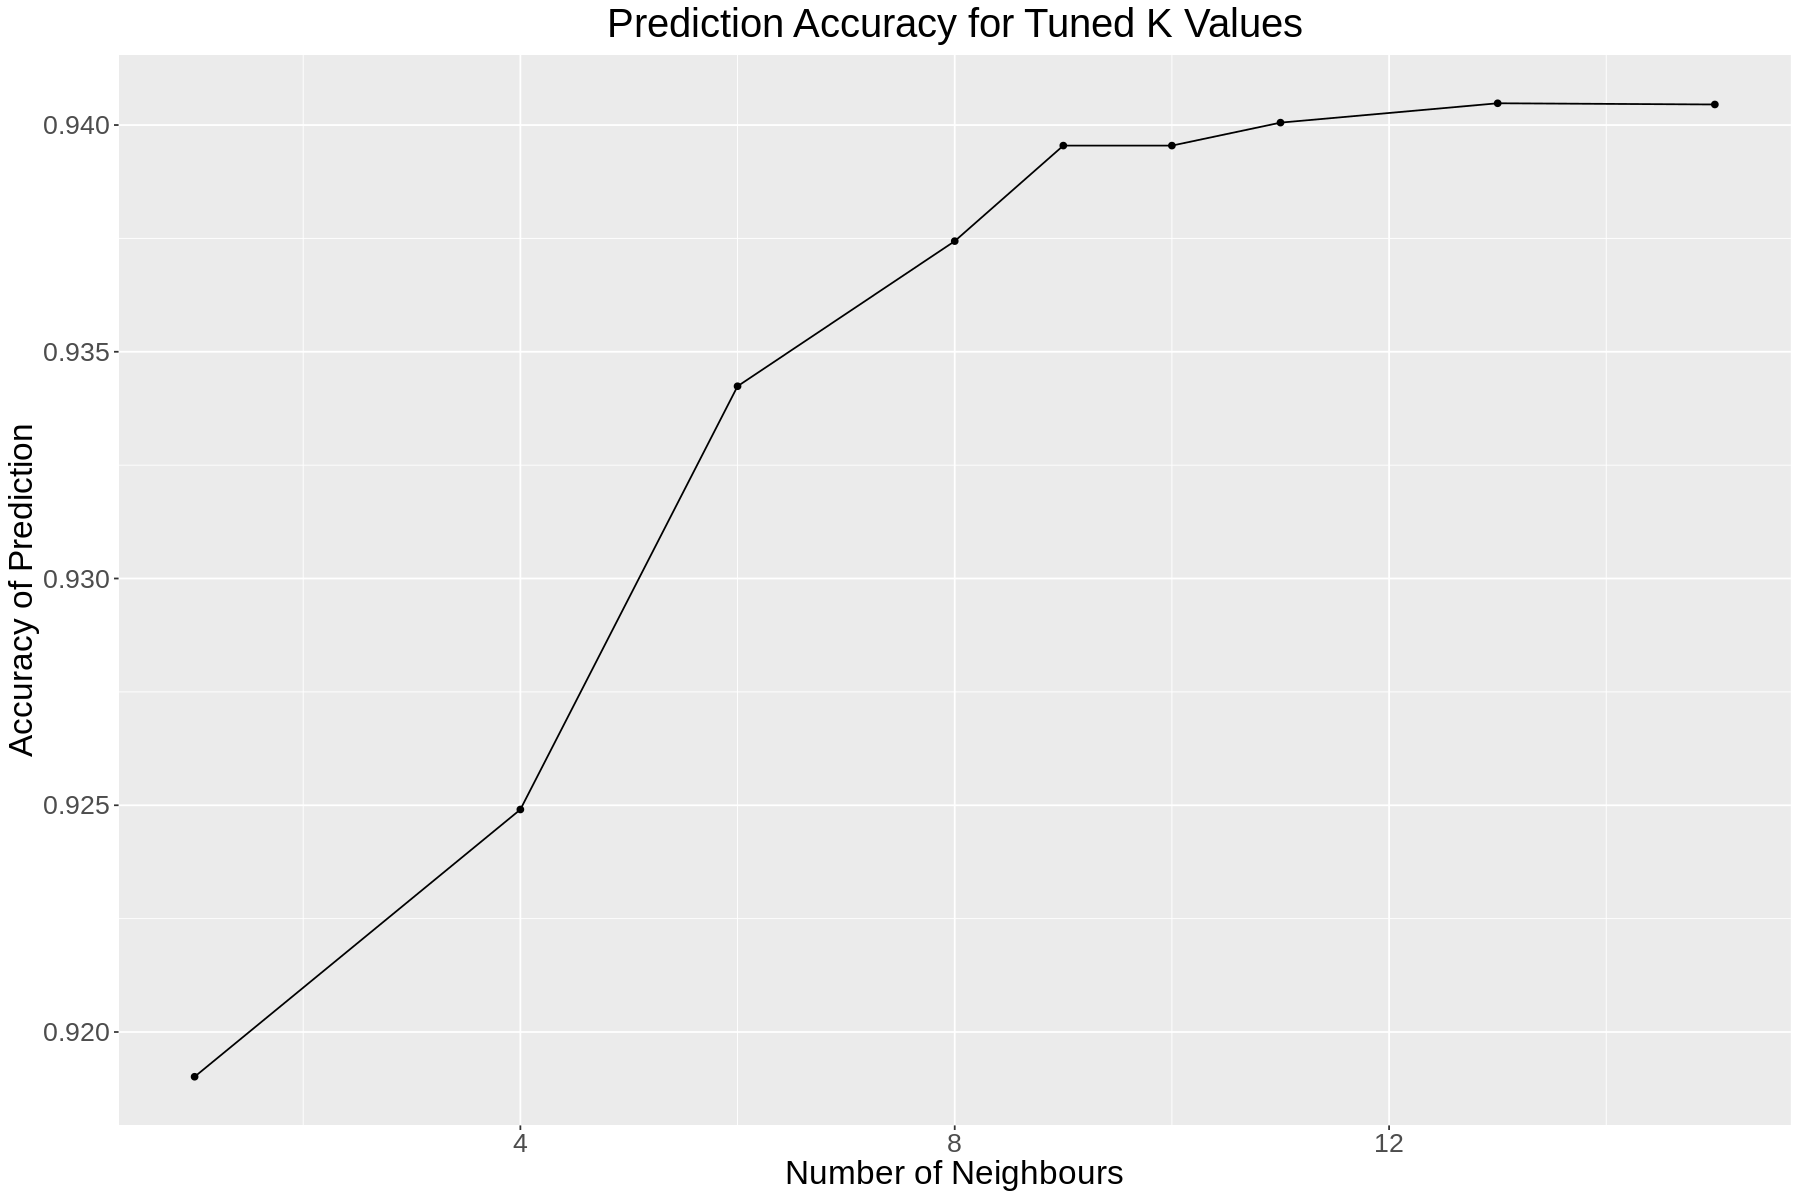

In [77]:
options(repr.plot.width= 15, repr.plot.height= 10)

accuracies_plot = accuracies %>% 
                ggplot(aes(x = neighbors, y = mean)) + 
                geom_point() +
                geom_line() + 
                labs(x = "Number of Neighbours", y = "Accuracy of Prediction") +
                ggtitle("Prediction Accuracy for Tuned K Values") + 
                theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20)) 

accuracies_plot

Working with 9 neighbours

In [61]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>%
            set_engine("kknn") %>%
            set_mode("classification")

knn_fit = workflow() %>%
            add_recipe(spotify_recipe_3) %>%
            add_model(knn_spec) %>%
            fit(data = spotify_train)

testing_predicted_9 = predict(knn_fit, spotify_test) %>%
                bind_cols(spotify_test) %>%
                metrics(truth = popular, estimate = .pred_class) %>%
                filter(.metric == "accuracy") 

testing_predicted_9

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.93976


Working with 15 neighbours

In [62]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) %>%
            set_engine("kknn") %>%
            set_mode("classification")

knn_fit_2 = workflow() %>%
            add_recipe(spotify_recipe_3) %>%
            add_model(knn_spec_2) %>%
            fit(data = spotify_train)

testing_predicted_15 = predict(knn_fit, spotify_test) %>%
                bind_cols(spotify_test) %>%
                metrics(truth = popular, estimate = .pred_class) %>%
                filter(.metric == "accuracy") 

testing_predicted_15

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.93976


In [63]:
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9190133,5,0.001065499,Model1
4,accuracy,binary,0.9249067,5,0.001654838,Model2
6,accuracy,binary,0.9342400,5,0.001535014,Model3
8,accuracy,binary,0.9374400,5,0.001895210,Model4
9,accuracy,binary,0.9395467,5,0.001728506,Model5
10,accuracy,binary,0.9395467,5,0.001716120,Model6
11,accuracy,binary,0.9400533,5,0.001855490,Model7
13,accuracy,binary,0.9404800,5,0.001844921,Model8
15,accuracy,binary,0.9404533,5,0.001809899,Model9
